# 6. 합성곱 신경망 2

## 6.1 이미지 분류를 위한 신경망

### 6.1.1 LeNet-5
- 수표에 쓴 손글씨 숫자를 인식하는 딥러닝 구조
- 현재는 CNN의 초석이 됨
- 합성곱(convolutional)과 다운 샘플링(sub_sampling)을 반복적으로 거치면서 마지막에 완전 연결층에서 분류를 수행

In [1]:
# 필요한 라이브러리 호출
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout

In [4]:
# LeNet-5 클래스 생성
num_classes = 2
class LeNet(Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        
        self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=input_shape, padding="same"))
        self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',padding='valid'))
        self.add(Flatten())
        self.add(Dense(120, activation='relu'))
        self.add(Dense(84, activation='relu'))
        self.add(Dense(nb_classes, activation='softmax'))

        self.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [5]:
# LeNet-5 모델 생성
model = LeNet((100,100,3), num_classes)
model.summary()

Model: "le_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 6)       456       
_________________________________________________________________
average_pooling2d_1 (Average (None, 50, 50, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 16)        2416      
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               4062840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 170

In [22]:
# 파라미터 초기화 및 데이터 호출
EPOCHS = 100
BATCH_SIZE =32
image_height = 100
image_width = 100
train_dir = 'data/chap6/catanddog/train/'
valid_dir = 'data/chap6/catanddog/validation/'

In [23]:
# 이미지 데이터 증가
train = ImageDataGenerator(
                rescale=1./255,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1)

train_generator = train.flow_from_directory(train_dir,
                                            target_size=(image_height, image_width),
                                            color_mode = "rgb",
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode = "categorical")

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(valid_dir,
                                            target_size=(image_height, image_width),
                                            color_mode="rgb",
                                            batch_size=BATCH_SIZE,
                                            seed=7,
                                            shuffle=True,
                                            class_mode="categorical")
train_num = train_generator.samples
valid_num = valid_generator.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [26]:
# 텐서보드에서 모델 훈련 과정 살펴보기
log_dir = "data/chap6/img/log6-1/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1, profile_batch=0)
model.fit(train_generator,
          epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_num // BATCH_SIZE,
          callbacks=[tensorboard_callback],
          verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 575ms/step - loss: 0.3038 - accuracy: 0.8669 - val_loss: 1.5355 - val_accuracy: 0.5729
Epoch 2/100
12/12 [==============================] - 4s 361ms/step - loss: 0.2031 - accuracy: 0.9235 - val_loss: 1.1882 - val_accuracy: 0.6250
Epoch 3/100
12/12 [==============================] - 5s 376ms/step - loss: 0.1984 - accuracy: 0.9150 - val_loss: 1.4056 - val_accuracy: 0.6042
Epoch 4/100
12/12 [==============================] - 4s 353ms/step - loss: 0.1553 - accuracy: 0.9377 - val_loss: 1.5085 - val_accuracy: 0.6146
Epoch 5/100
12/12 [==============================] - 4s 355ms/step - loss: 0.1472 - accuracy: 0.9547 - val_loss: 1.5975 - val_accuracy: 0.6458
Epoch 6/100
12/12 [==============================] - 4s 351ms/step - loss: 0.3476 - accuracy: 0.8895 - val_loss: 2.1297 - val_accuracy: 0.5000
Epoch 7/100
12/12 [==============================] - 5s 416ms/step - loss: 0.6444 - accuracy: 0.7448 - val_loss: 1.0966 - val_accuracy: 0.5417

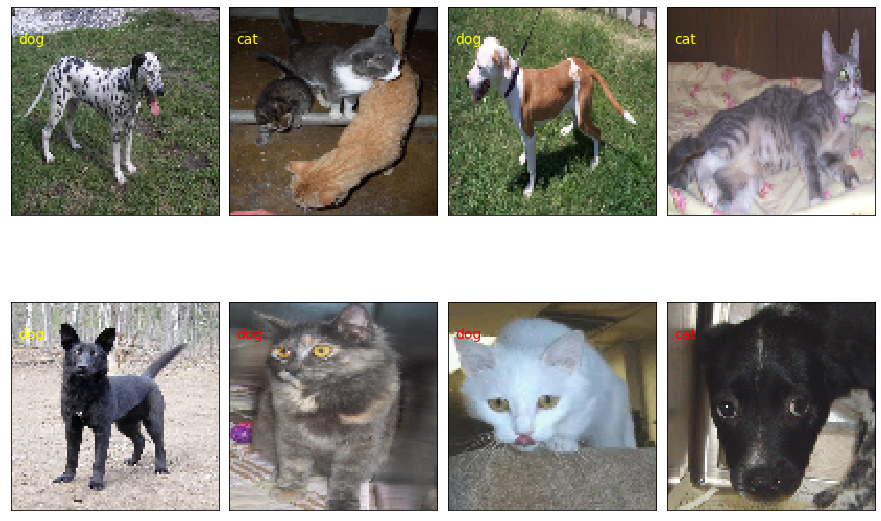

In [28]:
# 이미지 데이터셋 분류에 대한 예측
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_generator))
prediction_values = model.predict_classes(validation)

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')

    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

# AlexNet
- 합성곱층 5개, 완전연결층 3개
- 완전연결층은 소프트맥스 함수 사용
- GPU를 두 개를 사용
    GPU-1 : 컬러와 상관없는 정보를 추출하기 위한 커널 학습
    GPU-2 : 컬러와 관련된 정보를 추출하기 위한 커널 학습
- 활성화함수는 relu
- 파라미터 약 6000만개

In [1]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [10]:
# 모델 생성
num_classes = 2 # 개와 고양이 

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        
        self.add(Conv2D(96, kernel_size=(11,11), strides=4,
                padding='valid', activation='relu',
                input_shape = input_shape,
                kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        self.add(Conv2D(256, kernel_size=(5,5), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(5,5), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        self.add(Conv2D(384, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(Conv2D(384, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(Conv2D(256, kernel_size=(3,3), strides=1,
                        padding='same', activation='relu',
                        kernel_initializer='he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding='valid', data_format='channels_last'))
        
        self.add(Flatten())
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(4096, activation='relu'))
        self.add(Dense(1000, activation='relu'))
        self.add(Dense(num_classes, activation='softmax'))

        self.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [11]:
# 모델 생성
model = AlexNet((100,100,3), num_classes)
model.summary()

Model: "alex_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 23, 23, 96)        34944     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 256)       614656    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 384)         885120    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 384)         1327488   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         8

In [16]:
# 데이터 호출 및 데이터셋 전처리(증가)
EPOCHS = 100
BATCH_SIZE = 32
image_height = 100
image_width = 100
train_dir = 'data/chap6/catanddog/train/'
valid_dir = 'data/chap6/catanddog/validation/'

train = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1)

train_generator = train.flow_from_directory(train_dir,
                                            target_size=(image_height, image_width),
                                            color_mode="rgb",
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

valid = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid.flow_from_directory(valid_dir,
                                            target_size=(image_height, image_width),
                                            color_mode="rgb",
                                            batch_size=BATCH_SIZE,
                                            seed=7,
                                            shuffle=True,
                                            class_mode="categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples
                                            

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [17]:
# 텐서보드 설정 및 모델 훈련
log_dir = 'data/chap6/img/log6-2/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

model.fit(train_generator,
          epochs=EPOCHS,
          steps_per_epoch=train_num // BATCH_SIZE,
          validation_data=valid_generator,
          validation_steps=valid_num // BATCH_SIZE,
          callbacks = [tensorboard_callback],
          verbose=1)

Epoch 1/100
12/12 [==============================] - 17s 1s/step - loss: 4.7312 - accuracy: 0.4674 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 0.6956 - accuracy: 0.4589 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 16s 1s/step - loss: 0.6948 - accuracy: 0.4788 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 0.6942 - accuracy: 0.5099 - val_loss: 0.7329 - val_accuracy: 0.5000
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 0.6992 - accuracy: 0.5212 - val_loss: 0.6952 - val_accuracy: 0.4896
Epoch 6/100
12/12 [==============================] - 15s 1s/step - loss: 0.6915 - accuracy: 0.5326 - val_loss: 0.6934 - val_accuracy: 0.5104
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 0.6925 - accuracy: 0.5260 - val_loss: 0.6939 - val_accuracy: 0.4896
Epoch 8/100
1

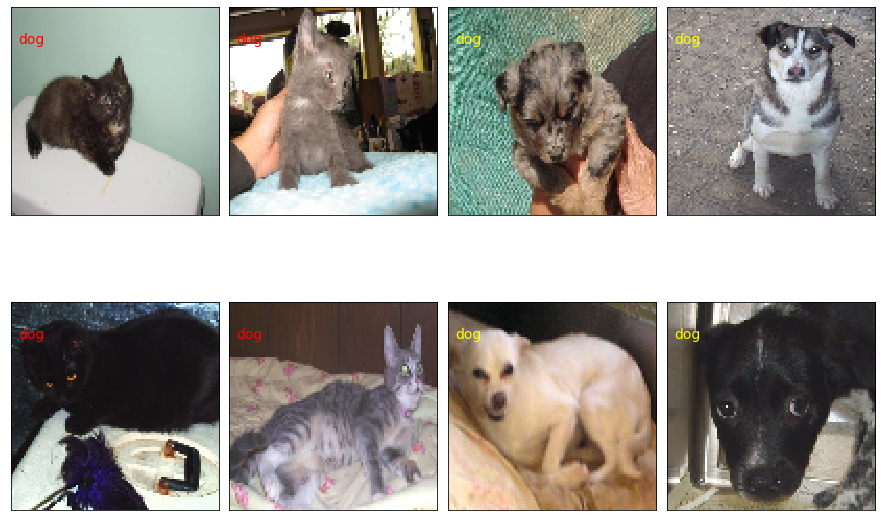

In [19]:
# 분류에 대한 예측
class_names = ['cat', 'dog']  # 고양이와 개
validation, label_batch = next(iter(valid_generator))    # validation input과 label
prediction_values = model.predict_classes(validation)    # validation input을 model에 적용 -> 예측값

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 사진 8개
for i in range(8):
    # 2x4 subplots
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])

    # 사진 하나 가져와
    ax.imshow(validation[i,:], cmap=plt.cm.gray_r, interpolation='nearest')

    # 그 사진에 대한 예측결과값 도 가져와서 실제값이랑 맞는지 확인
    if prediction_values[i] == np.argmax(label_batch[i]):
        ax.text(3, 17, class_names[prediction_values[i]], color='yellow', fontsize=14)    # 맞으면 노랑색으로 label 표시
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)       # 틀리면 빨간색으로 labe 표시


In [26]:
a, b = valid_generator[0]
print(a)
print('------------------------안녕-------------------------')
print(b)

[[[[0.62352943 0.5882353  0.5294118 ]
   [0.6156863  0.5803922  0.52156866]
   [0.6117647  0.5764706  0.5176471 ]
   ...
   [0.5411765  0.5019608  0.4666667 ]
   [0.54901963 0.50980395 0.47450984]
   [0.53333336 0.52156866 0.49411768]]

  [[0.61960787 0.58431375 0.5254902 ]
   [0.61960787 0.58431375 0.5254902 ]
   [0.62352943 0.5882353  0.5294118 ]
   ...
   [0.5294118  0.4901961  0.454902  ]
   [0.5529412  0.5137255  0.4784314 ]
   [0.54509807 0.53333336 0.5058824 ]]

  [[0.61960787 0.58431375 0.5254902 ]
   [0.61960787 0.58431375 0.5254902 ]
   [0.6156863  0.5803922  0.52156866]
   ...
   [0.53333336 0.49411768 0.45882356]
   [0.5411765  0.5019608  0.4666667 ]
   [0.5294118  0.5176471  0.4901961 ]]

  ...

  [[0.5647059  0.4431373  0.36078432]
   [0.5529412  0.43137258 0.34901962]
   [0.54509807 0.42352945 0.34117648]
   ...
   [0.454902   0.3647059  0.34117648]
   [0.39607847 0.32156864 0.29411766]
   [0.4156863  0.3647059  0.33333334]]

  [[0.58431375 0.46274513 0.3803922 ]
   [0.5

In [27]:
validation

array([[[[0.53333336, 0.6117647 , 0.5686275 ],
         [0.5411765 , 0.61960787, 0.5764706 ],
         [0.54509807, 0.62352943, 0.5803922 ],
         ...,
         [0.70980394, 0.79215693, 0.7568628 ],
         [0.7058824 , 0.78823537, 0.75294125],
         [0.7058824 , 0.7843138 , 0.7490196 ]],

        [[0.53333336, 0.6117647 , 0.5686275 ],
         [0.5411765 , 0.61960787, 0.5764706 ],
         [0.54509807, 0.62352943, 0.5803922 ],
         ...,
         [0.70980394, 0.79215693, 0.7568628 ],
         [0.7058824 , 0.78823537, 0.75294125],
         [0.7058824 , 0.7843138 , 0.7490196 ]],

        [[0.5372549 , 0.6156863 , 0.57254905],
         [0.5372549 , 0.6156863 , 0.57254905],
         [0.5411765 , 0.61960787, 0.5764706 ],
         ...,
         [0.7058824 , 0.78823537, 0.75294125],
         [0.7019608 , 0.7843138 , 0.7490196 ],
         [0.69803923, 0.7803922 , 0.74509805]],

        ...,

        [[0.5529412 , 0.5372549 , 0.5411765 ],
         [0.56078434, 0.54509807, 0.54901963]

### 6.1.3 VGGNet
> 합성곱층의 파라미터개수를 줄이고 훈련시간을 개선하려고 탄생

- 네트워크 계층의 총 개수에 따라 여러 유형의 VGGNet이 존재(VGG16, VGG19 등)
- VGG16는 파라미터 총 1억 3300만개
- VGG16이든 VGG19이든  
    - 모든 합성곱 커널의 크기는 3x3
    - 최대 풀링 커널의 크기는 2x2, 스트라이드 2

In [28]:
# 필요한 라이브러리 호출
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2    # 얼굴 인식, 물체 식별, 이미지 결합 등 작업이 가능한 오픈 소스 라이브러리

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
# VGG 네트워크 생성
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(128, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(256, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(256, kernel_size=(3,3), padding='same',
                        activation='relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding='same',
        activation='relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
        activation='relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu', input_shape=input_shape))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
                        activation='relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding='same',
        activation='relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation='softmax'))

        self.compile(optimizer=tf.keras.optimizers.Adam(0.003),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])



In [35]:
# VGG19 모델 출력
model = VGG19(input_shape=(224,224,3))
model.summary()

Model: "vg_g19_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 56, 56, 256)       295

In [39]:
# 사전 훈련된 VGG19 가중치 내려받기 및 클래스 정의
model.load_weights("data/chap6/vgg19_weights_tf_dim_ordering_tf_kernels.h5")
classes = {282: 'cat',
           681: 'notebook, notebook computer',
           970: 'alp'}   # 검증용으로 사용될 클래스 세 개만 적용

Text(0.5, 1.0, 'alp')

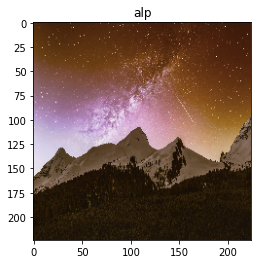

In [43]:
# 이미지 호출 및 예측
# image1 = cv2.imread('data/chap6/labtop.jpg')
image1 = cv2.imread('data/chap6/starrynight.jpeg')
# image1 = cv2.imread('data/chap6/labtop.jpg')
image1 = cv2.resize(image1, (224,224))
plt.figure()
plt.imshow(image1)
image1 = image1[np.newaxis, :]    # 차원 확장
predicted_value = model.predict_classes(image1)
plt.title(classes[predicted_value[0]])    # 출력에 대한 타이틀

### 6.1.4 GoogLeNet
> 주어진 하드웨어 자원을 최대한 효율적으로 이용하면서 학습 능력은 극대화할 수 있는 깊고 넓은 신경망

- 인셉션(Inception) 모듈을 추가함
    - 특징을 효율적으로 추출하기 위해 1x1, 3x3, 5x5의 합성곱 연산을 각각 수행
    - 3x3 최대 풀링은 입력과 출력의 높이와 너비가 같아야 하므로 풀링 연산에서는 드물게 패딩을 추가해야 한다.
    - 희소연결(sparse connectivity)
        - CNN은 합성곱, 풀링, 완전연결층이 서로 밀집(dense)하게 연결되어 있다.
        - 이러한 신경망 대신 관련성(correlation)이 높은 노드끼리만 연결하는 방법을 희소연결이라고 한다.
        - 연산량이 적어지고 과적합도 해결 가능.
- 심층 신경망에서 계층이 많고(뉴런이 많고) 깊으면(계층이 많으면) 인식률은 좋아지지만, 과적합이나 기울기 소멸 문제를 비롯한 학습 시간 지연과 연선 속도 등의 문제가 존재한다. 인셉션 모듈은 이러한 문제를 해결할 수 있다.

6.1.5 ResNet
> 신경망의 효과적인 학습을 위한 레지듀얼(residual) 개념을 고안

- 신경망이 깊이가 깊어질수록 성능이 좋아지다가 일정 단계에 다다르면 성능이 나빠진다는 문제를 해결하기 위해 **레지듀얼 블록(residual block)**을 도입
    - 레지듀얼 블록은 기울기가 잘 전파될 수 있도록 일종의 숏컷(shotcut, skip connection)을 만들어 준다.
        - ResNet이 총 152개의 층으로 구성되어 있기 때문에 기울기 소멸 문제가 염려되는데 이를 숏컷으로 방지하였다.
- 기존 신경망의 입력값 x에 대한 출력값 y로의 매핑 함수 H(x)를 얻는 것이 아닌 **$F(x)+x$를 최소화하는 것을 목적**으로 한다.
$$H(x) = F(x) + x$$
    - F(x) : 레지듀얼 함수로 두 개의 합성곱층 사이에 위치한다.
    - $F(x)+x$를 최소화할 때, x는 변할 수 없는 값이므로 F(x)를 0에 가깝게 하는 것이 목적이 된다.
    - 이는 $F(x)=H(x)-x$를 최소화한다는 의미와 같다.
    - F(x)를 레지듀얼 함수로 불렀듯이 H(x)-x도 레지듀얼이 된다.
    - $F(x)+x=H(x)=x$가 되도록 학습시키면, $F(x)+x$의 미분값은 $F'(x)+1$로 무조건 1이상의 값이 도출된다. 이러면 오차가 0에 가깝게 수렴하는 기울기 소멸 문제가 해결된다.

- ResNet의 구조는 아이덴티티 블록과 합성곱 블록으로 구성된다.
    - 아이덴티티 블록 : F(x)+x
    - 합성곱 블록 : x에 1x1 합성곱층을 거친 후 F(x)를 더해준 것

In [44]:
# 아이덴티티 블록
def res_identity(x, filters):
    x_skip = x    # 레지듀얼 블록을 추가하는 데 사용
    f1, f2 = filters

    # 첫 번째 블록
    x = Conv2D(f1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_regularizer=l2(0.001))(x)    # 합성곱
    x = BatchNormalization()(x)             # 2. BatchNormalization : 배치정규화. 데이터 평균을 0, 표준편차를 1로 분포시키는 것
    x = Activation(activations.relu)(x)     # 3. 렐루

    # 두 번째 블록
    x = Conv2D(f1, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))(x)    # 합성곱
    x = BatchNormalization()(x)            # 배치 정규화
    x = Activation(activations.relu)(x)    # 렐루
    
    # 세 번째 블록
    x = Conv2D(f2, kernel_size(1,1), strides=(1,1), padding='valid', kernel_regularizer=l2(0.001))(x)    # 합성곱
    x = BatchNormalization()(x)            # 정규화

    x = Add()([x, x_skip])    # 숏컷
    x = Activation(activations.relu)(x)    # 렐루
    return x

BatchNormalization  
입력 데이터의 분포는 앞 계층에서 업데이트된 가중치에 따라 변한다. 계층마다 변화되는 분포는 학습 속도를 늦추고 학습도 어렵게 한다. 따라서 평균 0, 표준편차 1로 분포시켜 성능 최적화를 이룬다. (8장에서 자세히)

In [46]:
# 합성곱 블록

def res_conv(x, s, filters):
    x_skip = x
    f1, f2 = filters


    # 첫 번째 블록
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)


    # 두 번째 블록
    x = Conv2D(f1, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x - Activation(activations.relu)(x)

    # 세 번째 블록
    x = Conv2D(f2, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # x 숏컷 : 이 때 x는 1x1 합성곱층을 거친 후 F(x)에 더해준다.
    x_skip = Conv2D(f2, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)
    return x